In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/daily.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df.dtypes

DATE            datetime64[ns]
TEAMNAME                object
USERCOUNT                int64
SECONDSSPENT             int64
QUANTITY                 int64
VOLUME                 float64
WEIGHT                 float64
PRICE                  float64
dtype: object

In [3]:
df = df[df['DATE'] > '2022-08-10']

In [4]:
teams = df['TEAMNAME'].unique()
df_multi_index = pd.MultiIndex.from_product([df['DATE'].unique(),
                                   teams], names=['DATE', 'TEAMNAME'])
df = df.set_index(['DATE', 'TEAMNAME']).reindex(df_multi_index, fill_value=0).reset_index()
df = df[df['TEAMNAME'] != 'ID9']

codes = dict(zip(df['TEAMNAME'].unique(), range(1, len(df['TEAMNAME'].unique())+1)))
df['TEAMNAME'] = df['TEAMNAME'].map(codes)
print(codes)
df

{'DP2': 1, 'DP1': 2, 'HP1': 3, 'DD': 4, 'HP2': 5, 'HD': 6}


,DATE,TEAMNAME,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
0,2022-08-16,1,1,552,28,0.812385,77.656000,608.40
1,2022-08-16,2,14,24312,1536,4.698062,528.972000,7106.06
2,2022-08-16,3,0,0,0,0.000000,0.000000,0.00
3,2022-08-16,4,0,0,0,0.000000,0.000000,0.00
4,2022-08-16,5,0,0,0,0.000000,0.000000,0.00
...,...,...,...,...,...,...,...,...
2087,2023-09-29,2,50,629794,386483,1182.841185,124143.482703,663067.42
2088,2023-09-29,3,1,784,46145,127.654466,14000.372667,69089.23
2089,2023-09-29,4,7,6695,332128,1090.899987,115141.810667,770403.11
2090,2023-09-29,5,3,9210,88845,288.663179,31449.018000,171143.45


In [5]:
# correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,TEAMNAME,USERCOUNT,SECONDSSPENT,QUANTITY,VOLUME,WEIGHT,PRICE
TEAMNAME,1.000000,-0.767246,-0.714005,-0.430706,-0.530093,-0.505770,-0.447103
USERCOUNT,-0.767246,1.000000,0.956668,0.542850,0.625968,0.604338,0.548369
SECONDSSPENT,-0.714005,0.956668,1.000000,0.565439,0.636814,0.623241,0.560882
QUANTITY,-0.430706,0.542850,0.565439,1.000000,0.874067,0.938353,0.609883
VOLUME,-0.530093,0.625968,0.636814,0.874067,1.000000,0.977215,0.723193
WEIGHT,-0.505770,0.604338,0.623241,0.938353,0.977215,1.000000,0.702359
PRICE,-0.447103,0.548369,0.560882,0.609883,0.723193,0.702359,1.000000


In [6]:
# split into train and test sets
cols = ['QUANTITY', 'VOLUME', 'WEIGHT', 'PRICE', 'TEAMNAME']

train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
train_X, train_y = train[cols], train['SECONDSSPENT']
test_X, test_y = test[cols], test['SECONDSSPENT']

In [7]:
dtrain_reg = xgb.DMatrix(train_X, train_y, enable_categorical=True)
dtest_reg = xgb.DMatrix(test_X, test_y, enable_categorical=True)

In [8]:
params = {"objective": "reg:squarederror", "tree_method": "hist", "learning_rate": 0.1, "max_depth": 5, "min_child_weight": 1, "n_estimators": 1000, "seed": 1234, "nthread": 5, "eval_metric": "mae"}
evals = [(dtrain_reg, "train"), (dtest_reg, "test")]
n = 10000

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=50,
   early_stopping_rounds=50
)

[18:25:52] WARNING: /var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_b2k4a2hea3/croot/xgboost-split_1675457783214/work/src/learner.cc:767: 
Parameters: { "n_estimators" } are not used.

[0]	train-mae:267938.89715	test-mae:150084.05097
[50]	train-mae:38624.20122	test-mae:57699.37061
[66]	train-mae:35227.42309	test-mae:58009.39364


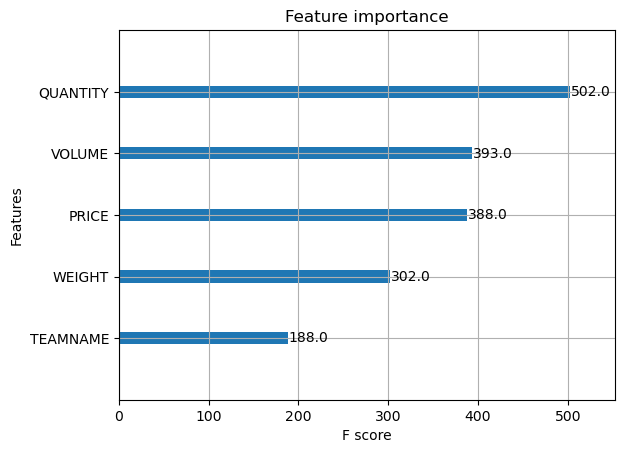

<Figure size 1600x1200 with 0 Axes>

In [9]:
xgb.plot_importance(model)
plt.figure(figsize = (16, 12))
plt.show()

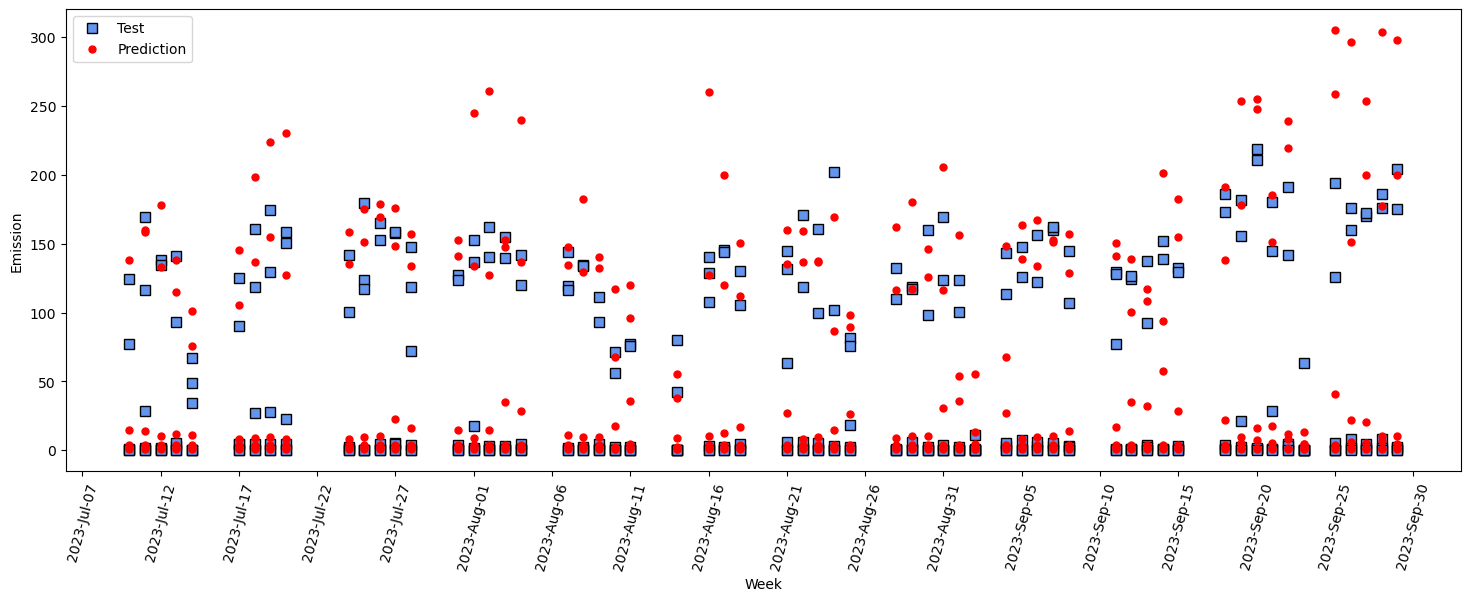

MAE: 16.114


In [12]:
yhat = model.predict(dtest_reg)
date = df['DATE'][train_size:]

fig, ax = plt.subplots()
fig.set_size_inches(18, 6)
ax.plot(date, test_y / 3600, 
        linestyle='none', 
        marker='s',
        markerfacecolor='cornflowerblue', 
        markeredgecolor='black',
        markersize=7,
        label='Test')
ax.plot(date, yhat / 3600, 
        linestyle='none',
        marker='o',
        markersize=5,
        color='red',
        label='Prediction')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b-%d'))
ax.set_xlabel('Week')
ax.set_ylabel('Emission')
plt.xticks(rotation=75)
ax.legend(loc='upper left')
plt.show()

mae = mean_absolute_error(test_y, yhat) / 3600
print('MAE: %.3f' % mae)